In [224]:
#####Dynamic Poisson Factrization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

In [225]:
#連続した日付を取得する関数
def daterange(_start, _end):
    for n in range((_end - _start).days):
        yield _start + timedelta(n)
        
#切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    return np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")

##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [226]:
####シミュレーションデータを作成####
##日付データを作成
#対象期間の日付と曜日情報を出力
start = datetime.strptime('2014-01-01', '%Y-%m-%d')
end   = datetime.strptime('2018-12-31', '%Y-%m-%d')
get_date = np.array([])
day_of_week = np.array([], dtype="int")
for day in daterange(start, end):
    get_date = np.append(get_date, day)
    day_of_week = np.append(day_of_week, day.weekday())
    
#日付を定義
index_week = np.array(np.where(day_of_week < 5)[0], dtype="int")
Timestamp = pd.Series(get_date).iloc[index_week]
date = pd.DataFrame({"date": Timestamp.astype("U")})
date_df = pd.merge(date, pd.DataFrame({"date": np.unique(date), "date_id": np.arange(date.shape[0])}), on="date", how="inner")
year = pd.DataFrame({"year": Timestamp.astype("U").str[:4]})
unique_year = np.unique(year)
year_df = pd.merge(year, pd.DataFrame({"year": unique_year, "year_id": np.arange(unique_year.shape[0])}), on="year", how="inner")
month = pd.DataFrame({"month": Timestamp.astype("U").str[5:7]})
unique_month = np.unique(month)
month_df = pd.merge(month, pd.DataFrame({"month": unique_month, "month_id": np.arange(unique_month.shape[0])}), on="month", how="inner")

#週を定義
new_week = day_of_week[index_week]
index = np.array(np.where((new_week-4)==0)[0], dtype="int")
week_n = index.shape[0]
week = np.repeat(0, new_week.shape[0])
for i in range(week_n):
    if i==0:
        get = np.arange(0, index[i]+1)
        week[get] = np.repeat(i, get.shape[0])
    else:
        get = np.arange(index[i-1]+1, index[i]+1)
        week[get] = np.repeat(i, get.shape[0])
        
#データフレームを作成
calendar_df = pd.concat((date_df, year_df, month_df, pd.DataFrame({"week_id": week})), axis=1)
date = np.array(calendar_df["date_id"], dtype="int")
year = np.array(calendar_df["year_id"], dtype="int")
month = np.array(calendar_df["month_id"], dtype="int")
week = np.array(calendar_df["week_id"], dtype="int")

In [227]:
##ニュースデータの生成
#データの定義
k = 10   
item = 300
element = 250
trend = 5
days = np.unique(date).shape[0]
years = np.unique(year).shape[0]
months = np.unique(month).shape[0]
weeks = np.unique(week).shape[0]
Lambda = np.random.gamma(50.0, 1/0.5, days)
n = np.random.poisson(Lambda, days)
N = np.sum(n)
k_vec = np.repeat(1.0, k)

In [228]:
##idとインデックスを定義
#idの定義
date_id = np.repeat(date, n)
year_id = np.repeat(year, n)
month_id = np.repeat(month, n)
week_id = np.repeat(week, n)

#インデックスを定義
date_list = [i for i in range(days)]
year_list = [i for i in range(years)]
month_list = [i for i in range(months)]
week_list = [i for i in range(weeks)]
for i in range(days):
    date_list[i] = np.array(np.where(date_id==i)[0], dtype="int")
for i in range(years):
    year_list[i] = np.array(np.where(year_id==i)[0], dtype="int")
for i in range(months):
    month_list[i] = np.array(np.where(month_id==i)[0], dtype="int")
for i in range(weeks):
    week_list[i] = np.array(np.where(week_id==i)[0], dtype="int")

In [229]:
##センチメントの状態の推移を生成
#モデルパラメータの定義
state = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.8389, 0.15, 0.01, 0.001, 0.0001],
               [0.15, 0.8089, 0.03, 0.001, 0.0001],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.0001, 0.001, 0.03, 0.8089, 0.15],
               [0.0001, 0.001, 0.01, 0.15, 0.8389]])

#状態推移を生成
s = np.repeat(0, weeks)
for i in range(weeks):
    if i==0:
        s[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        s[i] = np.argmax(np.random.multinomial(1, S2[s[i-1], ], 1))

#回帰行列を生成
scale = 1.5
beta_positive = np.abs(np.random.normal(0.0, 0.5, k))
beta_neutral = np.abs(np.random.normal(0.0, 0.25, k))
beta_negative = np.abs(np.random.normal(0.0, 0.5, k))
beta = np.vstack((scale*beta_positive, beta_positive, beta_neutral, beta_negative, scale*beta_negative))
        
#ニュースのtrendを生成
Pi = np.array([[0.3, 0.15, 0.3, 0.15, 0.1],
               [0.25, 0.15, 0.25, 0.15, 0.2],
               [0.2, 0.2, 0.2, 0.2, 0.2],
               [0.15, 0.25, 0.15, 0.25, 0.2],
               [0.15, 0.3, 0.15, 0.3, 0.1]])
trend_id = rmnom(Pi[s[week_id], ], N, state, 0)

#インデックスを定義
trend_list1 = [i for i in range(trend)]
trend_list2 = [i for i in range(trend)]
for i in range(trend):
    temp_list = [j for j in range(weeks)]
    trend_list1[i] = np.array(np.where(trend_id==i)[0], dtype="int")
    for j in range(weeks):
        temp_list[j] = np.array(np.where((week_id==j) & (trend_id==i))[0], dtype="int")
    trend_list2[i] = temp_list

In [230]:
##アイテムとエレメントの割当を生成
#トピック割当を生成
topic = 30
phi_item = np.random.dirichlet(np.repeat(0.1, item+1), topic)
phi_element = np.random.dirichlet(np.repeat(0.1, element+1), topic)
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), days)
z = np.array(rmnom(theta_topic[date_id, ], N, topic, 0), dtype="int16")

#多項分布からアイテムおよびエレメントを生成
item_id = np.repeat(0, N)
element_id = np.repeat(0, N)
for i in range(days):
    item_id[date_list[i]] = rmnom(phi_item[z[date_list[i]], ], n[i], item, 0)
    element_id[date_list[i]] = rmnom(phi_element[z[date_list[i]], ], n[i], element, 0)
    
#アイテムのインデックス
item_list = [i for i in range(item+1)]
item_n = np.repeat(0, item+1)
for i in range(item+1):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]
    
#エレメントのインデックス
element_list = [i for i in range(element+1)]
element_n = np.repeat(0, element+1)
for i in range(element+1):
    element_list[i] = np.array(np.where(element_id==i)[0], dtype="int")
    element_n[i] = element_list[i].shape[0]

In [231]:
##応答変数を生成
while True:
    #事前分布の設定
    alpha = np.repeat(-0.5, k)
    tau1 = np.diag(np.repeat(0.1, k))
    tau2 = np.diag(np.repeat(0.005, k))

    #モデルパラメータの生成
    beta_u = np.random.gamma(0.3, 1/1.0, days)
    beta_v = np.random.gamma(0.25, 1/1.0, item+1)
    theta_u = np.random.gamma(0.7, 1/1.0, k*days).reshape(days, k)
    theta_v = np.vstack((np.random.gamma(0.4, 1/0.75, k*item).reshape(item, k), np.repeat(1.0, k)))
    theta_e = np.vstack((np.random.gamma(0.75, 1/1.5, k*element).reshape(element, k), np.repeat(1.0, k)))
    theta_g = [i for i in range(trend)]
    for i in range(trend):
        theta = np.zeros((weeks, k))
        for j in range(weeks):
            if j==0:
                theta[j, ] = np.random.multivariate_normal(alpha, tau1, 1)
            else:
                theta[j, ] = np.random.multivariate_normal(theta[j-1, ], tau2, 1)
        theta_g[i] = theta

    #生成したパラメータをコピー
    betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy(); thetat_g = theta_g.copy()

    #ポアソン分布から頻度を生成
    uv = np.repeat(0.0, N)
    uv_neutral = theta_u[date_id, ] * theta_v[item_id, ] * theta_e[element_id, ]
    for i in range(trend):
        index = trend_list1[i]
        uv[index, ] += np.dot(uv_neutral[index, ] * np.exp(theta_g[i])[week_id[index], ], k_vec)
    mu = beta_u[date_id] + beta_v[item_id] + uv
    y = rtpois(mu, 0, 1000, N)
    y_factorial = scipy.special.gammaln(y+1)

    #break条件
    if np.max(y) < 100:
        break

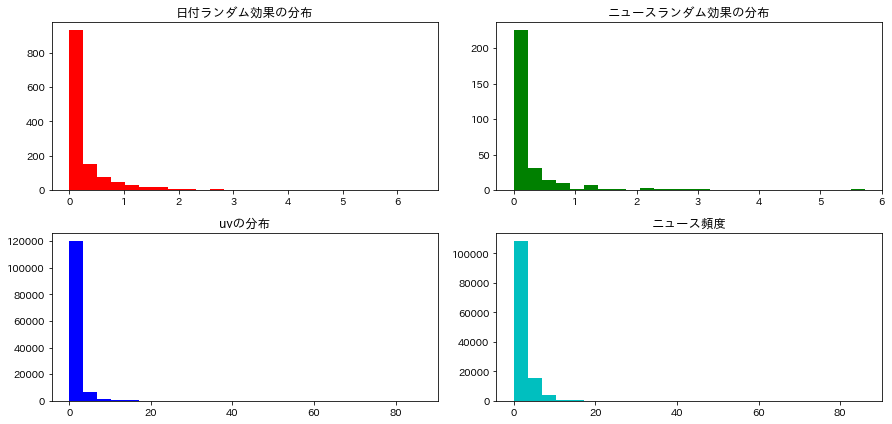

In [232]:
#生成したデータのヒストグラム
dt = [beta_u, beta_v, uv, y]
fig_range = np.append(np.array([np.min(beta_u), np.min(beta_v), np.min(uv), 0.0]), 
                      np.array([np.max(beta_u), np.max(beta_v), np.max(y), np.max(y)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["日付ランダム効果の分布", "ニュースランダム効果の分布", "uvの分布", "ニュース頻度"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [233]:
####Dynamic Poisson Factorizationを推定####
##アルゴリズムの設定
R = 1000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
intercept = np.repeat(1.0, N)[:, np.newaxis]

In [412]:
##パラメータの初期値
#事前分布の設定
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 0.1
tau1 = np.diag(np.repeat(0.25, k))
tau2 = [np.diag(np.repeat(0.1, k)) for j in range(trend)]
inv_tau1 = np.linalg.inv(tau1)
inv_tau2 = [np.linalg.inv(tau2[j]) for j in range(trend)]

#モデルパラメータの初期値
beta_u = np.random.gamma(0.25, 1/1.0, days)
beta_v = np.random.gamma(0.25, 1/1.0, item+1)
theta_u = np.random.gamma(1.0, 1/1.0, k*days).reshape(days, k)
theta_v = np.vstack((np.random.gamma(0.5, 1/1.0, k*item).reshape(item, k), np.repeat(1.0, k)))
theta_e = np.vstack((np.random.gamma(0.5, 1/1.0, k*element).reshape(element, k), np.repeat(1.0, k)))
theta_g = [np.random.multivariate_normal(np.repeat(-0.5, k), np.diag(np.repeat(0.2, k)), weeks) for j in range(trend)]

#パラメータの更新
beta_date = beta_u[date_id]
beta_item = beta_v[item_id]
theta_date = theta_u[date_id, ] 
theta_item = theta_v[item_id, ] 
theta_element = theta_e[element_id, ]
theta_trend = [np.exp(theta_g[j])[week_id[trend_list1[j]], ] for j in range(trend)]

#期待値の真値
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv

In [418]:
##パラメータの真値
#事前分布の設定
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 0.1
tau1 = np.diag(np.repeat(0.25, k))
tau2 = [np.diag(np.repeat(0.1, k)) for j in range(trend)]
inv_tau1 = np.linalg.inv(tau1)
inv_tau2 = [np.linalg.inv(tau2[j]) for j in range(trend)]

#モデルパラメータの真値
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()
theta_g = thetat_g.copy()

#パラメータの更新
beta_date = beta_u[date_id]
beta_item = beta_v[item_id]
theta_date = theta_u[date_id, ] 
theta_item = theta_v[item_id, ] 
theta_element = theta_e[element_id, ]
theta_trend = [np.exp(theta_g[j])[week_id[trend_list1[j]], ] for j in range(trend)]

#期待値の真値
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv

In [399]:
####ギブスサンプリングでパラメータをサンプリング####
##潜在変数zをサンプリング
#潜在変数zの割当確率
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv
Prob = 1 - np.exp(-mu)

#潜在変数zから新しい変数を作成
z = np.random.binomial(1, Prob, N)
y_new = z * y

In [237]:
##経済状況ベクトルをサンプリング
#補助変数lambdaを更新
date_deploy = np.hstack((beta_date[:, np.newaxis], uv_deploy))
Lambda = date_deploy / mu[:, np.newaxis]

#事後分布のパラメータ
lambda_y = Lambda * y_new[:, np.newaxis]
lambda_h = np.hstack((intercept, uv_deploy / theta_date))
w1 = np.repeat(0.0, days); w2 = np.repeat(0.0, days)
W1 = np.zeros((days, k)); W2 = np.zeros((days, k))
for i in range(days):
    w1[i] = np.sum(lambda_y[date_list[i], 0]); w2[i] = np.sum(lambda_h[date_list[i], 0])
    W1[i, ] = np.sum(lambda_y[date_list[i], 1:], axis=0)
    W2[i, ] = np.sum(lambda_h[date_list[i], 1:], axis=0)
w1 = w1 + alpha1; w2 = w2 + beta1; W1 = W1 + alpha1; W2 = W2 + beta1

#ガンマ分布からパラメータをサンプリング
beta_u = np.random.gamma(w1, 1/w2, days)
theta_u = np.random.gamma(W1, 1/W2)
beta_date = beta_u[date_id]
theta_date = theta_u[date_id, ] 

#期待値の更新
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv


##アイテムベクトルをサンプリング
#補助変数lambdaを更新
item_deploy = np.hstack((beta_item[:, np.newaxis], uv_deploy))
Lambda = item_deploy / mu[:, np.newaxis]

#事後分布のパラメータ
lambda_y = Lambda * y_new[:, np.newaxis]
lambda_h = np.hstack((intercept, uv_deploy / theta_item))
w1 = np.repeat(0.0, item+1); w2 = np.repeat(0.0, item+1)
W1 = np.zeros((item, k)); W2 = np.zeros((item, k))
for i in range(item):
    w1[i] = np.sum(lambda_y[item_list[i], 0]); w2[i] = np.sum(lambda_h[item_list[i], 0])
    W1[i, ] = np.sum(lambda_y[item_list[i], 1:], axis=0)
    W2[i, ] = np.sum(lambda_h[item_list[i], 1:], axis=0)
w1[item] = np.sum(lambda_y[item_list[item], 0]); w2[item] = np.sum(lambda_h[item_list[item], 0])
w1 = w1 + alpha2; w2 = w2 + beta2; W1 = W1 + alpha2; W2 = W2 + beta2

#ガンマ分布からパラメータをサンプリング
beta_v = np.random.gamma(w1, 1/w2, item+1)
theta_v = np.vstack((np.random.gamma(W1, 1/W2), np.repeat(1.0, k)))
beta_item = beta_v[item_id]
theta_item = theta_v[item_id, ] 

#期待値の更新
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv


##エレメントベクトルをサンプリング
#補助変数lambdaを更新
Lambda = uv_deploy / mu[:, np.newaxis]

#事後分布のパラメータ
lambda_y = Lambda * y_new[:, np.newaxis]
lambda_h = uv_deploy / theta_element
W1 = np.zeros((element, k)); W2 = np.zeros((element, k))
for i in range(element):
    W1[i, ] = np.sum(lambda_y[element_list[i], ], axis=0)
    W2[i, ] = np.sum(lambda_h[element_list[i], ], axis=0)
w1 = w1 + alpha3; w2 = w2 + beta3; W1 = W1 + alpha3; W2 = W2 + beta3

#ガンマ分布からパラメータをサンプリング
theta_e = np.vstack((np.random.gamma(W1, 1/W2), np.repeat(1.0, k)))
theta_element = theta_e[element_id, ] 

#期待値の更新
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv

In [240]:
##trendベクトルをサンプリング


array([0.69314718, 0.69314718, 0.69314718, ..., 1.79175947, 1.79175947,
       0.        ])

In [414]:
#モデルの対数事後分布を計算する関数
def loglike(theta_g, inv_tau1, inv_tau2, mu, y, y_factorial, weeks, trend, k, k_vec, trend_list2):
    
    #ポアソンモデルの対数尤度関数
    LLi = y * np.log(mu) - mu - y_factorial

    #多変量正規分布の対数事前分布
    Prior = [np.repeat(0.0, weeks) for j in range(trend)]
    for j in range(trend):
        er = theta_g[j] - np.vstack((np.repeat(0.0, k), theta_g[j][:weeks-1, ]))
        Prior[j][0] = -1/2 * np.dot(np.dot(er[0, ], inv_tau1), er[0, ])
        Prior[j][1:] = -1/2 * np.dot(np.dot(er[1:, ], inv_tau2[j]) * er[1:, ], k_vec)

    #対数事後分布の和を計算
    Posterior = np.zeros((weeks, trend))
    for i in range(trend):
        for j in range(weeks):
            Posterior[j, i] = np.sum(LLi[trend_list2[i][j]]) + Prior[i][j]
    return Posterior

In [415]:
#対数事後分布の勾配を計算する関数

#モデルの期待値
uv = np.repeat(0.0, N)
uv_deploy = np.zeros((N, k))
uv_neutral = theta_date * theta_item * theta_element
for i in range(trend):
    index = trend_list1[i]
    uv_deploy[index, ] += uv_neutral[index, ] * theta_trend[i]
    uv[index, ] += np.dot(uv_deploy[index, ], k_vec)
mu = beta_date + beta_item + uv

#対数尤度の勾配ベクトルを定義
LLd = np.zeros((N, k))
for i in range(trend):
    index = trend_list1[i]
    x = uv_neutral[index, ]
    LLd[index, ] = y_new[index, np.newaxis] * (x * theta_trend[i] / mu[index, np.newaxis]) - x*theta_trend[i]


array([ -6.06942909,  15.12134328,   0.46021487, -11.3632543 ,
         2.56533244,  -5.04921401,   5.46494524,   4.06192607,
         2.3261659 ,  34.59732513])

In [416]:
np.sum(LLd[trend_list2[i][j], ], axis=0)

array([1.1840778 , 0.48922821, 0.15032888, 3.21447502, 0.23443547,
       1.6063465 , 0.42532074, 0.5209419 , 0.46417202, 0.11071189])

In [417]:
np.exp(thetat_g[i])[j, ]

array([0.56178915, 0.67271966, 0.54453641, 0.63396842, 0.70065101,
       0.34602685, 0.50771722, 0.41120222, 0.63331033, 0.96704537])

In [222]:
def fr(beta, x, y, y_factorial):
    Lambda = np.exp(np.dot(x, beta))
    LL = np.sum(y*np.log(Lambda) - Lambda - y_factorial)
    return -LL

#勾配ベクトルを定義
def gradient(beta, x, y, y_factorial):
    Lambda = np.exp(np.dot(x, beta))
    LLd = np.sum(y[:, np.newaxis]*x - x*Lambda[:, np.newaxis], axis=0)
    return -LLd


array([[1.45836472e-01, 2.73820166e-01, 5.84715623e-01, ...,
        3.11136632e-01, 8.58364696e-02, 2.35710855e+00],
       [3.72435923e-01, 2.82656317e-01, 7.73837535e-04, ...,
        4.29566454e-01, 7.82987982e-01, 1.12216558e+00],
       [1.48039766e-02, 5.21350117e-01, 1.30788607e+00, ...,
        3.14050467e-01, 1.58079408e-01, 1.52356375e-02],
       ...,
       [2.35249324e-01, 1.16915166e+00, 4.58202685e-01, ...,
        1.26146558e-01, 5.67793603e-01, 6.51566109e-02],
       [4.77181728e-01, 3.86090571e-01, 4.87498152e-01, ...,
        3.42186825e-01, 4.45370587e-02, 2.63845019e-03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [223]:
thetat_e

array([[8.64155830e-02, 3.40559738e-01, 5.32634949e-01, ...,
        2.99598647e-01, 5.68211558e-02, 2.31603621e+00],
       [3.51840061e-01, 1.96052022e-01, 1.35659957e-03, ...,
        4.67366526e-01, 7.17542252e-01, 1.06651871e+00],
       [3.31315109e-02, 5.01415452e-01, 1.26898670e+00, ...,
        2.72918735e-01, 1.18820807e-01, 1.27768829e-02],
       ...,
       [2.08492934e-01, 1.23085081e+00, 5.10978412e-01, ...,
        8.81377408e-02, 6.47151795e-01, 5.17751697e-02],
       [5.05092506e-01, 3.72306291e-01, 4.29847474e-01, ...,
        3.67566498e-01, 7.14191532e-02, 6.59283146e-03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])